# データ前処理

In [434]:
import codecs
import pandas as pd
import warnings
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')
train= pd.read_csv('train+.csv', sep=',',engine='c')

test=pd.read_csv('test+.csv', sep=',',engine='c')

train=train.drop(['Unnamed: 0'],axis=1)
test=test.drop(['Unnamed: 0'],axis=1)
train_tmp = train.copy()
test_tmp = test.copy()
# train_tmp = train_tmp.drop("賃料", axis=1)
df = pd.concat([train_tmp, test_tmp])
df=df.reset_index(drop=True)
df=df.rename(columns={'所在地':'address','アクセス':'access','間取り':'space','面積':'width','放送・通信':'information','築年数':'years','方角':'direction', '所在階':'bfloor','バス・トイレ':'bath','キッチン':'kitchen','室内設備':'service','駐車場':'parking','周辺環境':'enviroment','建物構造':'architect','契約期間':'period','lat':'lat','lng':'lng'})


In [435]:
def filter_dis(x):
    return np.sqrt((x.lat-35.681236)**2.0+(x.lng-139.767125)**2.0)

dis=(df.lat-35.681236)**2+(df.lng-139.767125)**2.0

def filter_conv(x):
    try :
        if "コンビニ" in x:
            return 1
        else :
            return 0
    except TypeError:
        return 0
conv=df.enviroment.map(filter_conv)

def filter_period(x):
    try :
        if "定期借家" in x:
            return 1
        else :
            return 0
    except TypeError:
        return 0
    

rp=df.period.map(filter_period)

def filter_period2(x):
    try :
        if "定期借家" in x:
            return "定期借家"
        else :
            return x
    except TypeError:
        return x
    
period=df.period.map(filter_period2)
#アクセス時間の前処理
access=df.access.str.split("\t\t",expand=True)

access.columns=['access0','access1','access2','access3']
access

def filter_eki(x):
    try :
        return x.split("\t")[1]
    except AttributeError:
        return " "
    except IndexError:
        return " "
def stationdelete(x):
    try:
        return x.replace("駅"," ")
    except AttributeError:
        return " "
kari0=access.applymap(filter_eki).access0
kari1=access.applymap(filter_eki).access1
kari2=access.applymap(filter_eki).access2
kari3=access.applymap(filter_eki).access3
kari=(kari0+kari1+kari2+kari3).map(stationdelete)

docs = np.array(kari)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

ekifeatures = count.get_feature_names()
# print(features)

nearstation=pd.DataFrame(bags.toarray(),columns=ekifeatures)

def srashdelete(x):
    try:
        return x.replace('／','')
    except AttributeError:
        return " "
se=df.service.map(srashdelete)
def filter_se(x):
    try :
        j=''
        for i in x:
            j+=i+' '
        return j
    except AttributeError:
        return " "
    except IndexError:
        return " "
se=se.str.split("\t").map(filter_se)

docs = np.array(se)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

sefeatures = count.get_feature_names()
# print(features)

se=pd.DataFrame(bags.toarray(),columns=sefeatures)

def filter_ts(x):
    try:
        return int(x.count("\t"))
    except IndexError:
        return 9
    except TypeError:
        return 9
    except AttributeError:
        return 9
sn=df.service.map(filter_ts)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [436]:
def srashdelete(x):
    try:
        return x.replace('／','')
    except AttributeError:
        return " "
ba=df.bath.map(srashdelete)
def filter_ba(x):
    try :
        j=''
        for i in x:
            j+=i+' '
        return j
    except AttributeError:
        return " "
    except IndexError:
        return " "
ba=ba.str.split("\t").map(filter_ba)

docs = np.array(ba)
count = CountVectorizer()
bags = count.fit_transform(docs)

print(bags.toarray())
# [[1 1 1 0]
#  [0 1 1 1]]

bafeatures = count.get_feature_names()
# print(features)

ba=pd.DataFrame(bags.toarray(),columns=bafeatures)

[[1 0 1 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 1 ... 1 1 0]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 0 0]]


In [437]:
access=access.applymap(lambda x:x.split("歩") if x is not None else None)
def filter_func1(x):
    try:
        return int(x[1].replace("分",""))
    except IndexError:
        return None
    except TypeError:
        return None
    except ValueError:
        return None
access=access.applymap(filter_func1)

accessmiss=access[access.access0.isnull()].index
access.access0.ix[accessmiss]=[15,1,15,15,7,9,10,11,8,10,13,8,8]
access=access.fillna(method='ffill',axis='columns')
access=access.fillna(method='bfill',axis='columns')
access[access.index==9845]=1
access[access.index==56577]=13

address=df.address
address=address.map(lambda x :x.replace("東京都",""))
address1=address.map(lambda x:x.split("区")[0])
address2=address.map(lambda x:x.split("区")[1])
address2=address2.map(lambda x:re.split("１|２|３|４|５|６|７|８|９|1|2|3|4|5|6|7|8|9|一丁目|二丁目|三丁目|四丁目|五丁目|六丁目|七丁目|八丁目",x)[0] )

#築年数の前処理
years=df.years
years.map(lambda x:str(x.split("年")[0]))
def filter_func2(x):
    kari=x.split("年")[0]
    if kari=="新築":
        return 0
    else :
        return int(kari)
years=years.map(filter_func2)

#間取りの前処理
import re
df["room"]=0
df["R"]=0
df["L"]=0
df["DK"]=0
df["LDK"]=0
df["D"]=0
df["K"]=0
df["S"]=0
df.room=df.space.apply(lambda x: int(re.split("L|D|K|S|R",x)[0]))
df.R=df.space.apply(lambda x: 1 if "R" in x else 0)
df.L=df.space.apply(lambda x: 1 if "L" in x else 0)
df.DK=df.space.apply(lambda x: 1 if "DK" in x else 0)
df.LDK=df.space.apply(lambda x: 1 if "LDK" in x else 0)
df.D=df.space.apply(lambda x: 1 if "D" in x else 0)
df.K=df.space.apply(lambda x: 1 if "K" in x else 0)
df.S=df.space.apply(lambda x: 1 if "S" in x else 0)

room=df.space.apply(lambda x: re.split("L|D|K|S|R",x)[0])
R=df.space.apply(lambda x: 1 if "R" in x else 0)
L=df.space.apply(lambda x: 1 if "L" in x else 0)
DK=df.space.apply(lambda x: 1 if "DK" in x else 0)
LDK=df.space.apply(lambda x: 1 if "LDK" in x else 0)
D=df.space.apply(lambda x: 1 if "D" in x else 0)
K=df.space.apply(lambda x: 1 if "K" in x else 0)
S=df.space.apply(lambda x: 1 if "S" in x else 0)
room=room.apply(lambda x:int(x))

bfloor=df.bfloor
import numpy as np
bfloor1=bfloor.map(lambda x: x.split("／")[0] if type(x) is str else "2階")
def floor_func(x):
    try :
        return x.split("／")[1]
    except IndexError:
        return x.split("／")[0]
    except AttributeError:
        return "2階"
bfloor2=bfloor.map(floor_func)

bfloor1=bfloor1.map(lambda x:x.replace("地下","-"))
bfloor2=bfloor2.map(lambda x:x.replace("地下","-"))
bfloor1=bfloor1.map(lambda x:x.split("階")[0])
bfloor2=bfloor2.map(lambda x:x.split("階")[0])
bfloor = pd.concat([bfloor1, bfloor2], axis=1)

bfloor.columns=["bfloor","height"]
#前処理
bfloor.bfloor[bfloor.bfloor==""]=None
bfloor=bfloor.fillna(method='ffill',axis='columns')
bfloor=bfloor.fillna(method='bfill',axis='columns')
bfloor=bfloor.applymap(lambda x:int(x))
bfloor1=bfloor.bfloor
bfloor2=bfloor.height
bfloor3=bfloor2-bfloor1

#面積の前処理
width=df.width
width=width.map(lambda x:float(x.replace("m2","")))

architect=df.architect
architect=architect.map(lambda x: 0 if "木造" in x else 1)

direction=df.direction
direction=direction.fillna(method='ffill')
# direction=direction.map(lambda x:1if "南" in x else 0)

def filter_pa(x):
    try:
        if '空有' in x:
            return 1
        else:
            return 0
    except TypeError:
        return 0
#前処理

pa=df.parking.map(filter_pa)

new=df.years.map(lambda x :1if x=="新築" else 0)
one=bfloor1.map(lambda x:1 if x==1 else 0)
bid=df.id
lat=df.lat
lng=df.lng

In [438]:
block={"ブロック":1,"その他":4,"鉄骨造":7,"木造":8,"ALC（軽量気泡コンクリート）":5,"RC（鉄筋コンクリート）":10,"HPC（プレキャスト・コンクリート（重量鉄骨））":2,"PC（プレキャスト・コンクリート（鉄筋コンクリート））":3,"鉄筋ブロック":0,"軽量鉄骨":6,"SRC（鉄骨鉄筋コンクリート）":9}
architect=df.architect.map(block)
dis=(lat-35.651816)**2+(lng-139.741531)**2
dis=(dis)*1000+1
access.access0=access.access0.max()-access.access0
# access.access1=access.access1.max()-access.access1
# karilist=list(df1.groupby("kari0").value.mean().sort_values().index )
# karidic={}
# for i,eki in enumerate(karilist):
#     karidic[eki]=i
# kari0=kari0.map(karidic)

In [439]:
# df.ix[[10876,20674,31364,41186,44494]].drop(["R","L","D","K","LDK","D","K","S","room","DK"],axis=1)

In [440]:
# df.ix[[20427,20926,20231,7491,5775]].drop(["R","L","D","K","LDK","D","K","S","room","DK"],axis=1)

In [441]:
addic={"葛飾":0, "足立":1,"江戸川":2,"板橋":3,"練馬":4,"杉並":5,"北":6,"中野":7,"大田":8,"豊島":9,"世田谷":10,"荒川":11,"墨田":12,"品川":13,"新宿":14,"文京":15,"江東":16,"台東":17,"目黒":18,"渋谷":19,"千代田":20,"中央":21,"港":22}
ad=address1.map(addic)

In [442]:
df_tofile=pd.concat([bid,access.access0,address1,address2,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,pa,rp,sn,nearstation,se,ba,dis,ad,kari0,ntown,period], axis=1)
# df_tofile=pd.concat([bid,access.access0,address1,address2,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,pa,rp,sn,nearstation,se,dis,ad], axis=1)
# df_tofile=pd.concat([bid,access.access0,address1,years,lat,lng,room,L,D,S,bfloor1,bfloor2,bfloor3,width,architect,direction,ih,wm,pa,air,rp,flooring,bal,loft,sn,sharetoilet,separatebath], axis=1)
df_tofile=pd.merge(df_tofile, train[["id","賃料"]], how='outer', on='id')

df_tofile.columns=["id","access","address","town","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","pa","rp","sn"]+list(nearstation.columns)+list(se.columns)+list(ba.columns)+["dis","ad","kari0","ntown","period"]+["value"]
# df_tofile.columns=["id","access","address","town","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","pa","rp","sn"]+list(nearstation.columns)+list(se.columns)+["dis","ad"]+["value"]
# df_tofile.columns=["id","access","address","years","lat","lng","room","L","D","S","bfloor","height","floordif","width","architect","direction","ih","wm","pa","air","rp","flooring","bal","loft","sn","sharetoilet","separatebath"]+["value"]
# df_tofile=df_tofile.drop(["L","D","ih"],axis=1)
df_tofile=df_tofile.drop("id",axis=1)
# df_tofile=df_tofile.drop(df_tofile.index[30539])
df_tofile=df_tofile.drop(df_tofile.index[20926])
df_tofile=df_tofile.drop(df_tofile.index[20427])
df_tofile=df_tofile.drop(df_tofile.index[20231])
df_tofile=df_tofile.drop(df_tofile.index[7491])
df_tofile=df_tofile.drop(df_tofile.index[5775])
# df_tofile=df_tofile.drop(df_tofile.index[5093])
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [443]:
# #数値型の特徴量だけ
# df_num = df_tofile.select_dtypes(include="number")
# df_num = df_num
 
# #相関行列を作成
# corrmat = df_num.corr()
 
# #相関行列のpriceの列と、特徴量の名前をデータフレームに
# corrPrice = pd.DataFrame({"features":df_num.columns,"corr_Price":corrmat["value"]},index=None)
# corrPrice = corrPrice.reset_index(drop=True)
# corrPrice.style.background_gradient()

In [444]:
# df1=df_tofile[["access","ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","ntown","bfloor","rp","value"]] #15305
df1=df_tofile[["access","ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","ntown","bfloor","value"]] #15305さらに強い
# df1=df_tofile[["ad","years","lat","lng","L","D","height","width","エレベーター","architect","dis","bfloor","rp","town","value"]] #15305

In [445]:
df1.isnull().sum()

access           0
ad               0
years            0
lat              0
lng              0
L                0
D                0
height           0
width            0
エレベーター           0
architect        0
dis              0
ntown            0
bfloor           0
value        31262
dtype: int64

In [446]:
from sklearn.model_selection import train_test_split, GridSearchCV

train = df1.dropna()
test=df1[df1.isnull().any(axis=1)]
testX=test.dropna()
X = pd.get_dummies(train)

#　目的変数に家賃単価を代入する
y = train.value
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [447]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib
matplotlib.matplotlib_fname()
import matplotlib as mpl
mpl.get_configdir()
import matplotlib as mpl
mpl.font_manager._rebuild() 
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAexGothic'


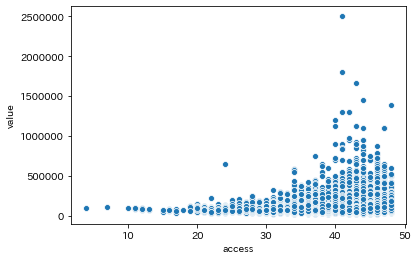

In [449]:
sns.scatterplot(x="access",y="value",data=train)

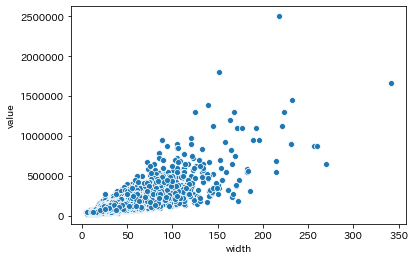

In [450]:
sns.scatterplot(x="width",y="value",data=train)

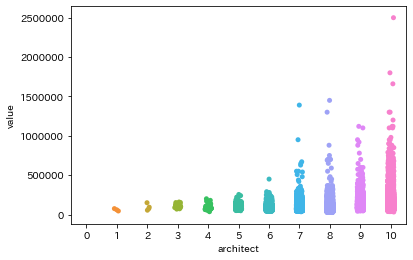

In [451]:
sns.stripplot(x="architect",y="value",data=df1)

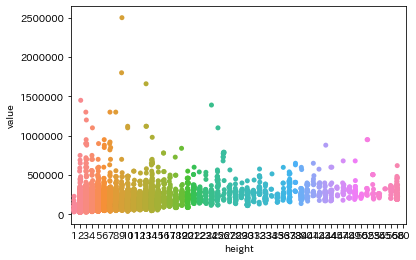

In [452]:
sns.stripplot(x="height",y="value",data=df1)

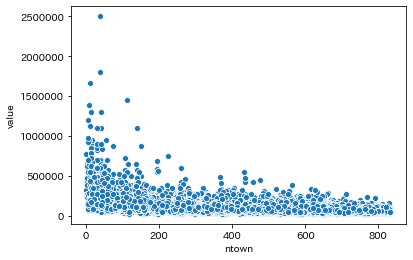

In [453]:
sns.scatterplot(x="ntown",y="value",data=df1)

In [454]:
# townlist=list(train.groupby("town").value.mean().sort_values().index)
# towndic={}
# for i, feat in enumerate(townlist):
#     towndic[feat]=i
# towndic
# ntown=df1.town.map(towndic)
# ntown[ntown.isnull()]=280
# ntown=834-ntown
# ntownlist=list(ntown[ntown.isnull()].index)


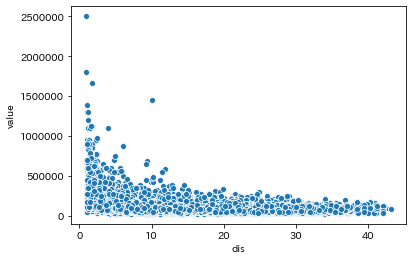

In [455]:
sns.scatterplot(x="dis",y="value",data=train)


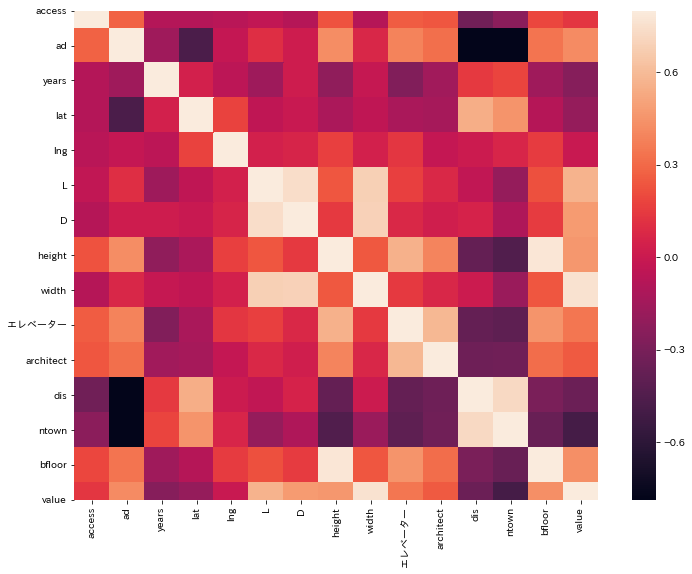

In [456]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

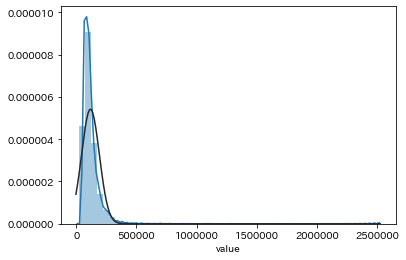

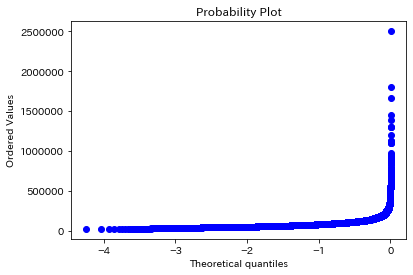

In [457]:
from scipy import stats
from scipy.stats import norm
sns.distplot(df1["value"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["value"], plot=plt)

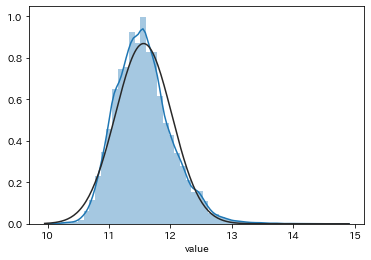

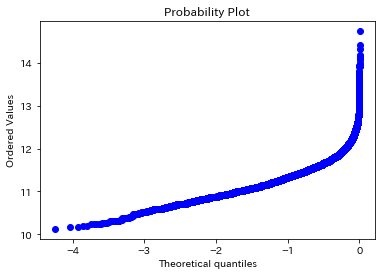

In [458]:
df1["value"]=np.log(df1.value)
# df1["value"]=stats.boxcox( df1.value, lmbda =-1 )
#transformed histogram and normal probability plot
sns.distplot(df1.value.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.value, plot=plt)

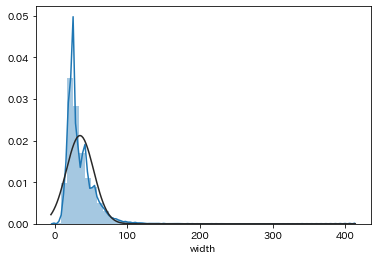

<Figure size 432x288 with 0 Axes>

In [459]:
sns.distplot(df1["width"].dropna(), fit=norm);
fig = plt.figure()
# res = stats.probplot(df1["width"], plot=plt)

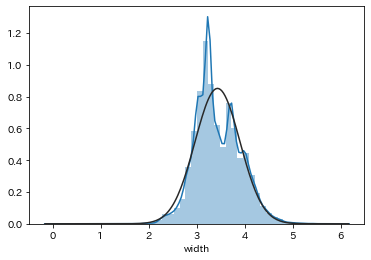

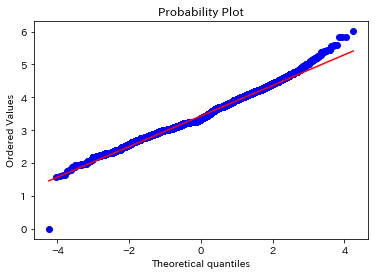

In [460]:
df1["width"]=np.log(df1.width)
#transformed histogram and normal probability plot
sns.distplot(df1.width.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.width, plot=plt)

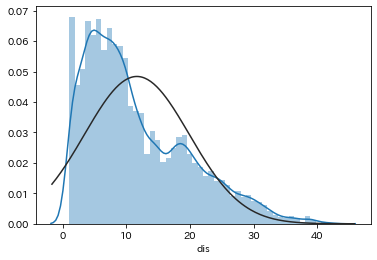

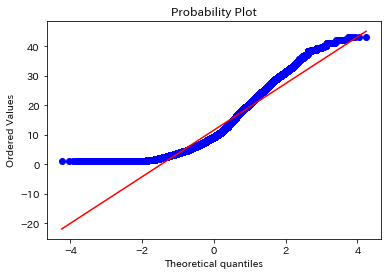

In [461]:
sns.distplot(df1["dis"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["dis"], plot=plt)

In [462]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy import stats

# fig = plt.figure(figsize=(6.0, 6.0))
# aaa=pd.DataFrame()
# list_lambda = [-2, -1, -0.5, 0, 0.5, 1, 2]
# for i, i_lambda in enumerate(list_lambda):
#     aaa[ 'val_'+str(i) ] = stats.boxcox( df1.dis, lmbda = i_lambda )
#     fig.add_subplot(4, 2, i+1).hist(aaa['val_'+str(i)], bins=20, color='r', alpha=0.5, density=True)
#     plt.title("lambda="+str(list_lambda[i]))
#     plt.xlabel('val')
#     plt.ylabel('density')

# aaa[ 'val_auto' ], best_lambda = stats.boxcox( df1.dis)
# fig.add_subplot(4, 2, 8).hist(aaa['val_auto'], bins=20, color='r', alpha=0.5, density=True)
# plt.title("lambda="+str(round(best_lambda, 2)))
# plt.xlabel('val')
# plt.ylabel('density')

# fig.tight_layout()
# fig.show()
# plt.show()

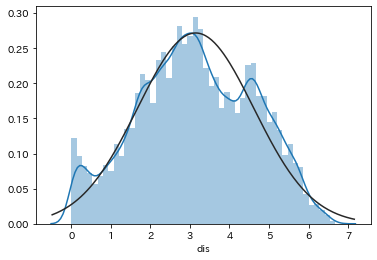

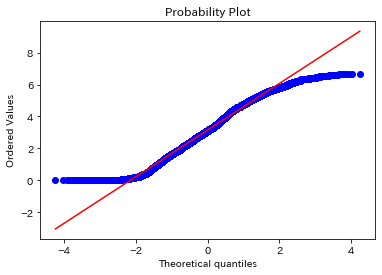

In [463]:
df1["dis"]=stats.boxcox( df1.dis, lmbda =0.28 )
#transformed histogram and normal probability plot
sns.distplot(df1.dis.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.dis, plot=plt)

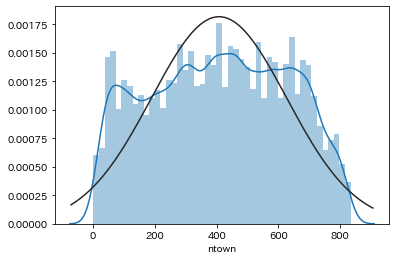

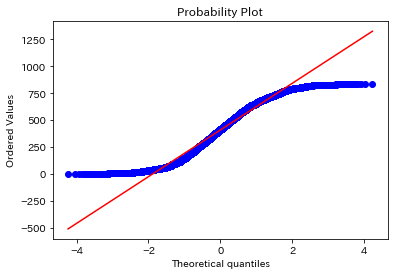

In [464]:
sns.distplot(df1["ntown"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["ntown"], plot=plt)

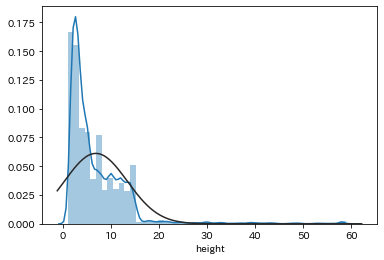

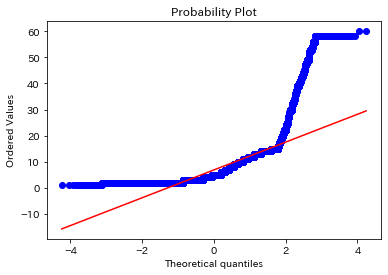

In [465]:
from scipy import stats
from scipy.stats import norm
sns.distplot(df1["height"].dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1["height"], plot=plt)

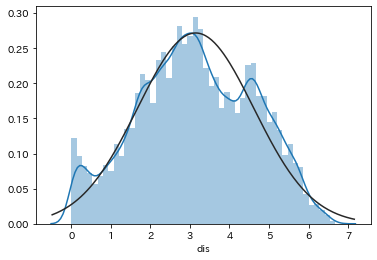

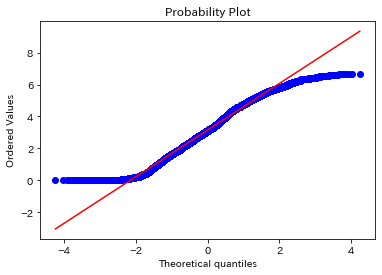

In [466]:
df1["height"]=stats.boxcox( df1.height, lmbda =0.28 )
#transformed histogram and normal probability plot
sns.distplot(df1.dis.dropna(), fit=norm);
fig = plt.figure()
res = stats.probplot(df1.dis, plot=plt)

In [467]:
# from scipy import stats
# from scipy.stats import norm
# sns.distplot(df1["access0"].dropna(), fit=norm);
# fig = plt.figure()
# res = stats.probplot(df1["access0"], plot=plt)

In [468]:
# df1["access0"]=np.log(df1.access0)
# #transformed histogram and normal probability plot
# sns.distplot(df1.access0.dropna(), fit=norm);
# fig = plt.figure()
# res = stats.probplot(df1.access0, plot=plt)

In [469]:
from sklearn.model_selection import train_test_split, GridSearchCV

train = df1.dropna()
test=df1[df1.isnull().any(axis=1)]
test= pd.get_dummies(test).drop(["value",],axis=1)
X = pd.get_dummies(train).drop(["value",],axis=1)

#　目的変数に家賃単価を代入する
y = train.value
train_X, valid_X,train_y, valid_y = train_test_split(X,y,test_size=0.2,random_state=43)

In [470]:
#重回帰分析
import sklearn
from sklearn.linear_model import LinearRegression as LR

model=LR()

model.fit(train_X, train_y)

linearpred=model.predict(valid_X)

In [471]:
model.score(valid_X,valid_y)

0.9192334676251045

In [472]:
from sklearn.ensemble import RandomForestRegressor as RFR
 

rg = RFR(n_jobs=-1, random_state=2525)
 
rg.fit(train_X,train_y)
print(rg.score(valid_X,valid_y))
from sklearn.metrics import mean_squared_error
print("randomforest :"+str(np.sqrt(mean_squared_error(np.exp(valid_y),np.exp(rg.predict(valid_X))))) )

0.956624857964559
randomforest :15320.51861047704


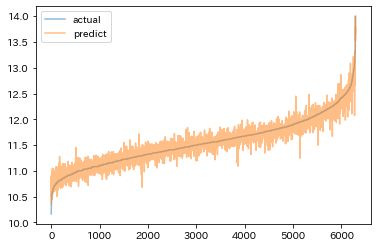

In [432]:

checktesty=valid_y.sort_values()
checktestX=valid_X.ix[list(checktesty.index)]
checktesty=checktesty.reset_index(drop=True)#これと

checkpred=pd.DataFrame(rg.predict(checktestX))#これ
# checktesty.plot()
# checkpred.plot()
check=pd.concat([checktesty,checkpred], axis=1)
check.columns=["actual","predict"]
# checktesty
check.plot(alpha=0.5)

In [653]:
fti = rg.feature_importances_

print('Feature Importances:')
for i,feat in enumerate(valid_X.columns):
    print('\t{0:10s} : {1:>.6f}'.format(feat, fti[i]))

Feature Importances:
	access     : 0.006446
	ad         : 0.020600
	years      : 0.056802
	lat        : 0.010228
	lng        : 0.008409
	L          : 0.415183
	D          : 0.000772
	height     : 0.008041
	width      : 0.253743
	エレベーター     : 0.002696
	architect  : 0.022291
	dis        : 0.075888
	ntown      : 0.113859
	bfloor     : 0.004215
	rp         : 0.000828


In [546]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rg, X, y)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np

import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.9547919  0.95450702 0.95484143]
Average score: 0.9547134491015674


In [547]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import optuna

class RidgeCV():
    model_cls = Ridge

    def __init__(self, n_trials=100):
        self.n_trials = n_trials

    def fit(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
        elif isinstance(X, pd.DataFrame):
            X = X.reset_index(drop=True)
            y = y.reset_index(drop=True)

        self.X = X
        self.y = y

        study = optuna.create_study(direction='maximize')
        study.optimize(self, n_trials=self.n_trials)
        self.best_trial = study.best_trial

        print()
        print("Best score:", round(self.best_trial.value, 2))
        print("Best params:", self.best_trial.params)
        print()

        self.best_model = self.model_cls(**self.best_trial.params)
        self.best_model.fit(self.X, self.y)

    def predict(self, X):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X.values.reshape(1, -1))
        elif isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        return self.best_model.predict(X)

    def score(self, X, y):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)

        return self.best_model.score(X, y)

    def kfold_cv(self, model, splits=5):
        scores = []

        kf = KFold(n_splits=splits, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
            model.fit(X_train, y_train)
            scores.append(model.score(X_test, y_test))

        score = np.array(scores).mean()
        return score

import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

class XGBRegressorCV(RidgeCV):
    model_cls = xgb.XGBRegressor

    def __call__(self, trial):
        booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
        alpha = trial.suggest_loguniform('alpha', 1e-8, 1.0)

        max_depth = trial.suggest_int('max_depth', 1, 9)
        eta = trial.suggest_loguniform('eta', 1e-8, 1.0)
        gamma = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        grow_policy = trial.suggest_categorical(
            'grow_policy', ['depthwise', 'lossguide'])

        if booster == 'gbtree':
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy)
        elif booster == 'dart':
            sample_type = trial.suggest_categorical('sample_type',
                                                    ['uniform', 'weighted'])
            normalize_type = trial.suggest_categorical('normalize_type',
                                                       ['tree', 'forest'])
            rate_drop = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
            skip_drop = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
            model = self.model_cls(silent=1, booster=booster,
                                   alpha=alpha, max_depth=max_depth, eta=eta,
                                   gamma=gamma, grow_policy=grow_policy,
                                   sample_type=sample_type,
                                   normalize_type=normalize_type,
                                   rate_drop=rate_drop, skip_drop=skip_drop)

        score = self.kfold_cv(model)
        return score

xgbr = XGBRegressorCV(n_trials=20)
xgbr.fit(train_X, train_y)

[I 2019-10-23 21:29:27,872] Finished trial#0 resulted in value: 0.9612816700560544. Current best value is 0.9612816700560544 with parameters: {'booster': 'gbtree', 'alpha': 0.0020212366147052446, 'max_depth': 9, 'eta': 1.4580612734891115e-07, 'gamma': 4.37990980280852e-05, 'grow_policy': 'lossguide'}.
[I 2019-10-23 21:29:44,090] Finished trial#1 resulted in value: 0.9568252494369434. Current best value is 0.9612816700560544 with parameters: {'booster': 'gbtree', 'alpha': 0.0020212366147052446, 'max_depth': 9, 'eta': 1.4580612734891115e-07, 'gamma': 4.37990980280852e-05, 'grow_policy': 'lossguide'}.


KeyboardInterrupt: 

In [ ]:
# print("lightgbm        :"+str(np.sqrt(mean_squared_error(np.exp(test_y),np.exp(gbm.predict(test_X,num_iteration=gbm.best_iteration))))) )

In [390]:

xgbr.fit(X, y)

pred=np.exp(xgbr.predict(test))

[I 2019-10-23 13:19:35,134] Finished trial#0 resulted in value: 0.9510919942158822. Current best value is 0.9510919942158822 with parameters: {'booster': 'gbtree', 'alpha': 6.000395853084827e-07, 'max_depth': 5, 'eta': 0.0040135114429623135, 'gamma': 4.032098889250773e-06, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:19:43,149] Finished trial#1 resulted in value: 0.9467448814678214. Current best value is 0.9510919942158822 with parameters: {'booster': 'gbtree', 'alpha': 6.000395853084827e-07, 'max_depth': 5, 'eta': 0.0040135114429623135, 'gamma': 4.032098889250773e-06, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:19:54,985] Finished trial#2 resulted in value: 0.9533044943609065. Current best value is 0.9533044943609065 with parameters: {'booster': 'gbtree', 'alpha': 1.831478179916323e-07, 'max_depth': 6, 'eta': 1.3015852333372284e-06, 'gamma': 0.09646484619535824, 'grow_policy': 'lossguide'}.
[I 2019-10-23 13:21:00,011] Finished trial#3 resulted in value: 0.961298531183189. Current b


Best score: 0.96
Best params: {'booster': 'dart', 'alpha': 1.8207208429912212e-05, 'max_depth': 9, 'eta': 3.071430581972498e-08, 'gamma': 1.4009180696836153e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.333976022460132e-06, 'skip_drop': 0.001276316855438467}

[13:40:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [394]:
pred=np.exp(xgbr.predict(test))

In [395]:
sub = pd.DataFrame(pd.read_csv("test.csv")['id'])
sub["value"] = list(pred)
sub.to_csv("submission2.csv", index = False)